In [56]:
import os
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')

import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import anndata as ad
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
from scripts.utils import load_from_pickle, save_to_pickle
from scipy.stats import fisher_exact, spearmanr

import gseapy as gp

import warnings
warnings.filterwarnings('ignore')
sc.set_figure_params(figsize=(6,6),dpi=120)

region_colors_dict = {
    'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
}

regions = list(region_colors_dict.keys())

In [2]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

club_markers = check_top_markers('Club epithelium')['gene'].tolist()

# Download the gene lists
gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

## Gene set overlap Venn diagram (Figure 5a)

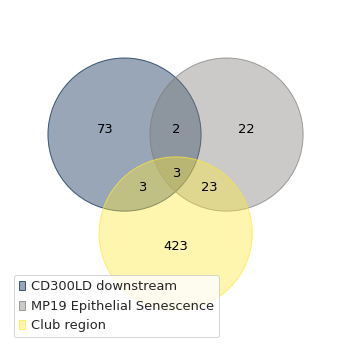

In [11]:
sns.set_theme(style='white')
sns.set_palette(sns.color_palette([region_colors_dict['Club epithelium']]))
from venn import venn

gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T
gene_set_df.rename(columns={'NLR associated':'High NLR-associated'},inplace=True)

set1_name = 'CD300LD downstream'
set1 = set(gene_set_df[set1_name].dropna())


set2_name = 'MP19 Epithelial Senescence'
set2 = set(gene_set_df[set2_name].dropna())

set3_name = 'Club region'
set3 = set(club_markers)

venn_data = {
            set1_name: set1,
            set2_name: set2,
            set3_name: set3,
            }
fig,ax = plt.subplots(figsize=(6,6))
# Create the Venn diagram
venn(venn_data,
    ax=ax,
    cmap='cividis',
    legend_loc='best'

)
plt.savefig('plots/score_correlations/venn_'+set1_name+'_'+set2_name+'_'+set3_name+'.pdf')
plt.show()

## He et al. 2021 prostate cancer mets scRNA-seq

In [ ]:

he_2021_dat = pd.read_csv('./sc-reference/he_2021/scp_tpm.tsv',sep = '\t',index_col=0)
he_2021_meta = pd.read_csv('./sc-reference/he_2021/scp_clustering.tsv',sep = '\t')

he_2021_adata = ad.AnnData(
    X=he_2021_dat.T,
    var=pd.DataFrame(index=he_2021_dat.index),
    obs = he_2021_meta
)
he_2021_adata.layers['tpm_counts'] = he_2021_adata.X.copy()

# Save into a h5ad file for easier access
he_2021_adata.write('./sc-reference/he_2021/adata.h5ad')

### Plotting gene set markers on the data (Figure 5b)

In [3]:
he_2021_adata = sc.read_h5ad('./sc-reference/he_2021/adata.h5ad')

# Selected based on the status as a Club region marker
genes = [
    'TACSTD2','CHI3L1','CEACAM1','SLPI','LCN2','LTF','S100P','S100A8','S100A9','SERPINB1','ANXA1'
]

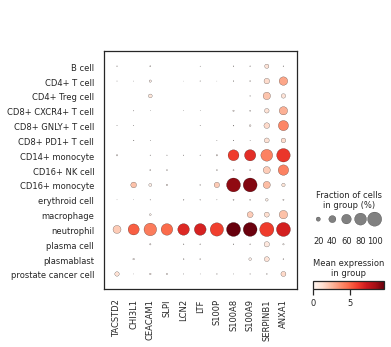

In [4]:
sns.set_theme(style='white')
#fig,ax = plt.subplots(figsize=(5,5))
fig,ax = plt.subplots(figsize=(5,5))
sc.pl.dotplot(he_2021_adata,var_names=genes,groupby='group',ax=ax,show=False,log=True)

#plt.savefig('plots/he_2021_metastases_club_episen_club_cd300ld_markers_dotplot.pdf',transparent=True)


plt.show()

In [51]:
# Save the source data
plot_df = pd.DataFrame(data=he_2021_adata[:,genes].layers['tpm_counts'].toarray(),
            columns=genes,
            index=he_2021_adata.obs_names
)

plot_df['group'] = he_2021_adata.obs['group']

# Calcuclate means per cell type
mean_df = plot_df.groupby('group').mean().melt(ignore_index=False)

# Calculate percentages per cell type
plot_df.loc[:,genes] = (plot_df.loc[:,genes] != 0).astype(int)
pct_df = plot_df.groupby('group').mean().melt(ignore_index=False)

# Concatenate means and percentages in a long format
plot_df = pd.concat([mean_df,pct_df],axis=1,ignore_index=True).drop(columns=2).reset_index()

plot_df.columns= ['cell_type','gene','mean','pct']
plot_df.to_excel('./source_data/figure_5b.xlsx')

## Bulk data from TCGA & SU2C-PCF (Figure 5g, Figure 5h)

In [54]:
def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

gene_set_df = pd.read_excel('custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T
gene_sets_of_interest = gene_set_df.columns.tolist()
gene_sets = gene_set_df[gene_sets_of_interest].to_dict('list')

for key, value in gene_sets.items():
    # Remove NaN values from the list
    gene_sets[key] = [x for x in value if pd.notnull(x)]


gene_modules_dict = {
    'Club region': check_top_markers('Club epithelium')['gene'].tolist(),
                    }

gene_modules_dict = {**gene_modules_dict,**gene_sets}

# The club-like senescence signature is the overlap between Club region markers and MP19 Epithelial Senescence
gene_modules_dict['club_like_senescence'] = list(set(gene_modules_dict['Club region']).intersection(set(gene_modules_dict['MP19 Epithelial Senescence'])))


### TCGA untreated primary tumors

In [101]:
# Download the data from the Xena browser
# https://xenabrowser.net/datapages/?dataset=survival%2FPRAD_survival.txt&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
tcga_counts_dat = pd.read_csv('bulk_RNAseq/TCGA_PRAD/TCGA_PRAD_xenabrowser_counts_2FHiSeqV2.txt',sep='\t')
tcga_counts_dat = tcga_counts_dat.rename(columns={'sample':'gene_name'})

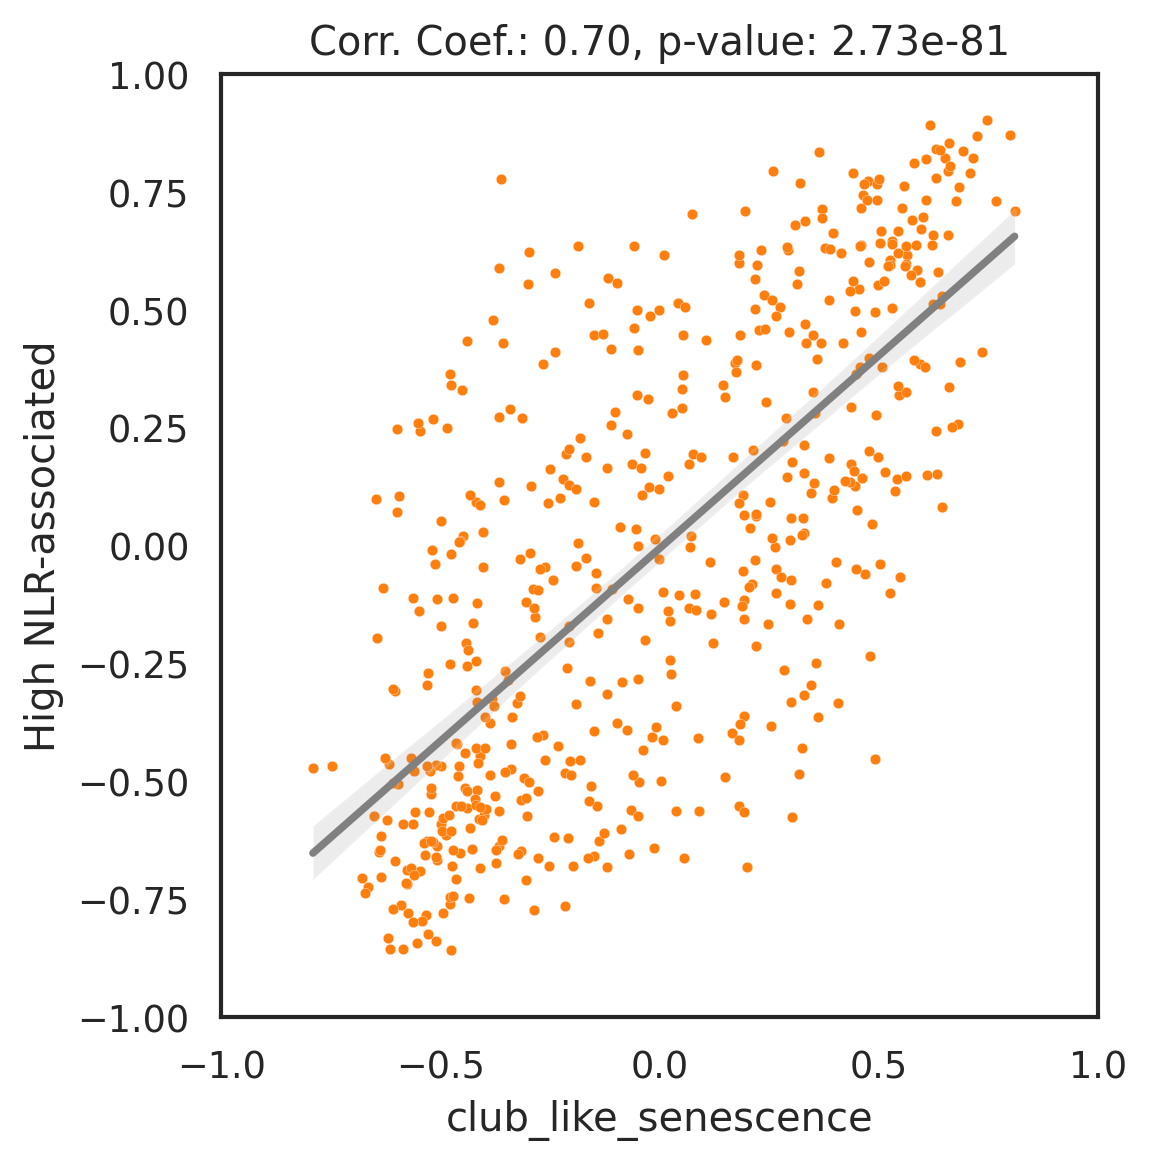

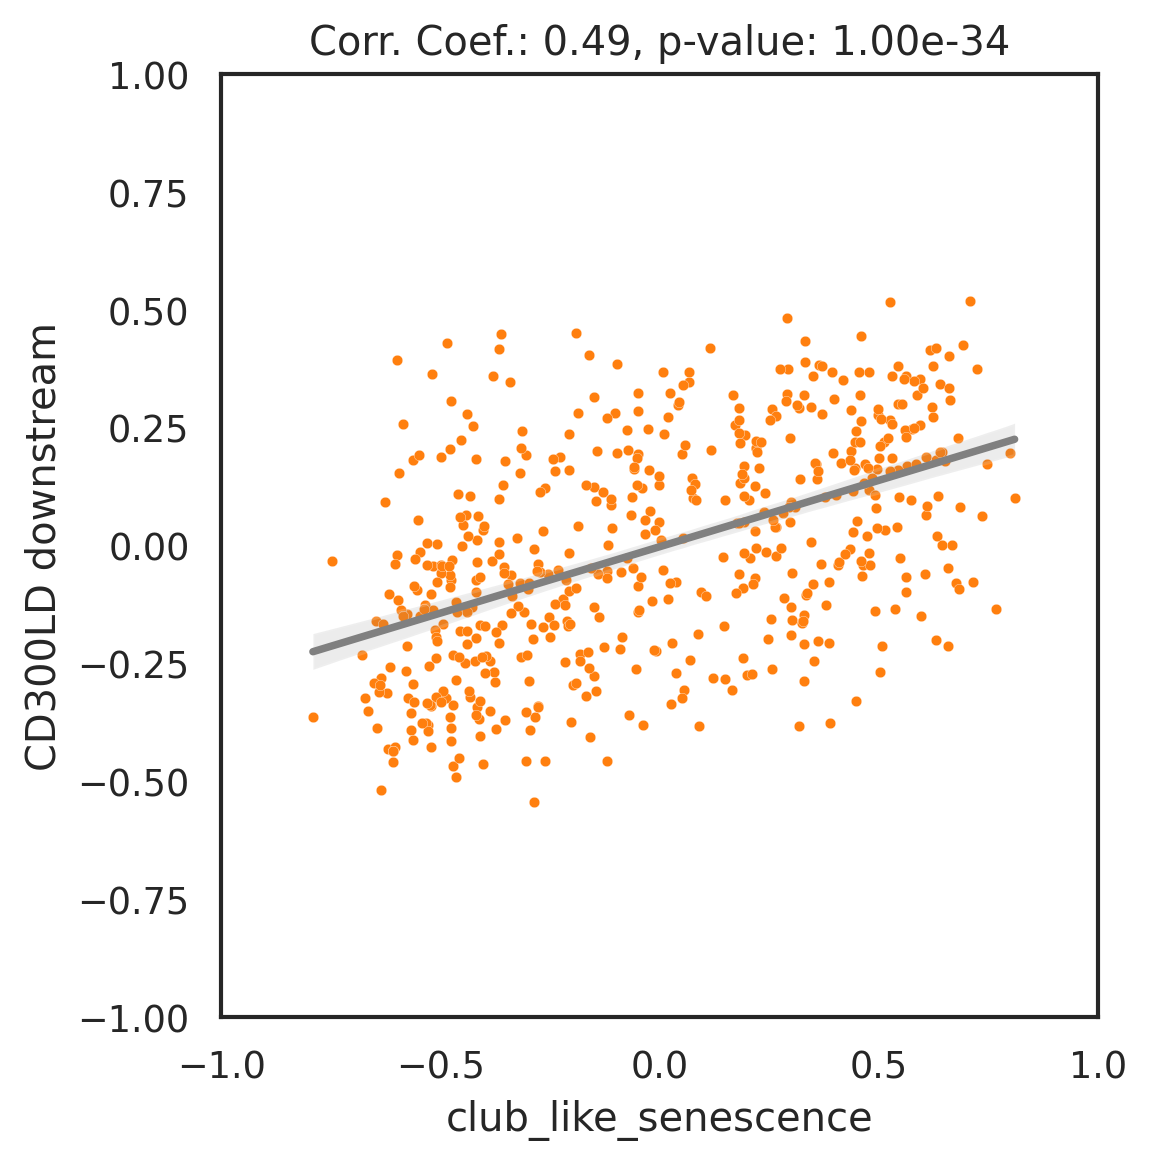

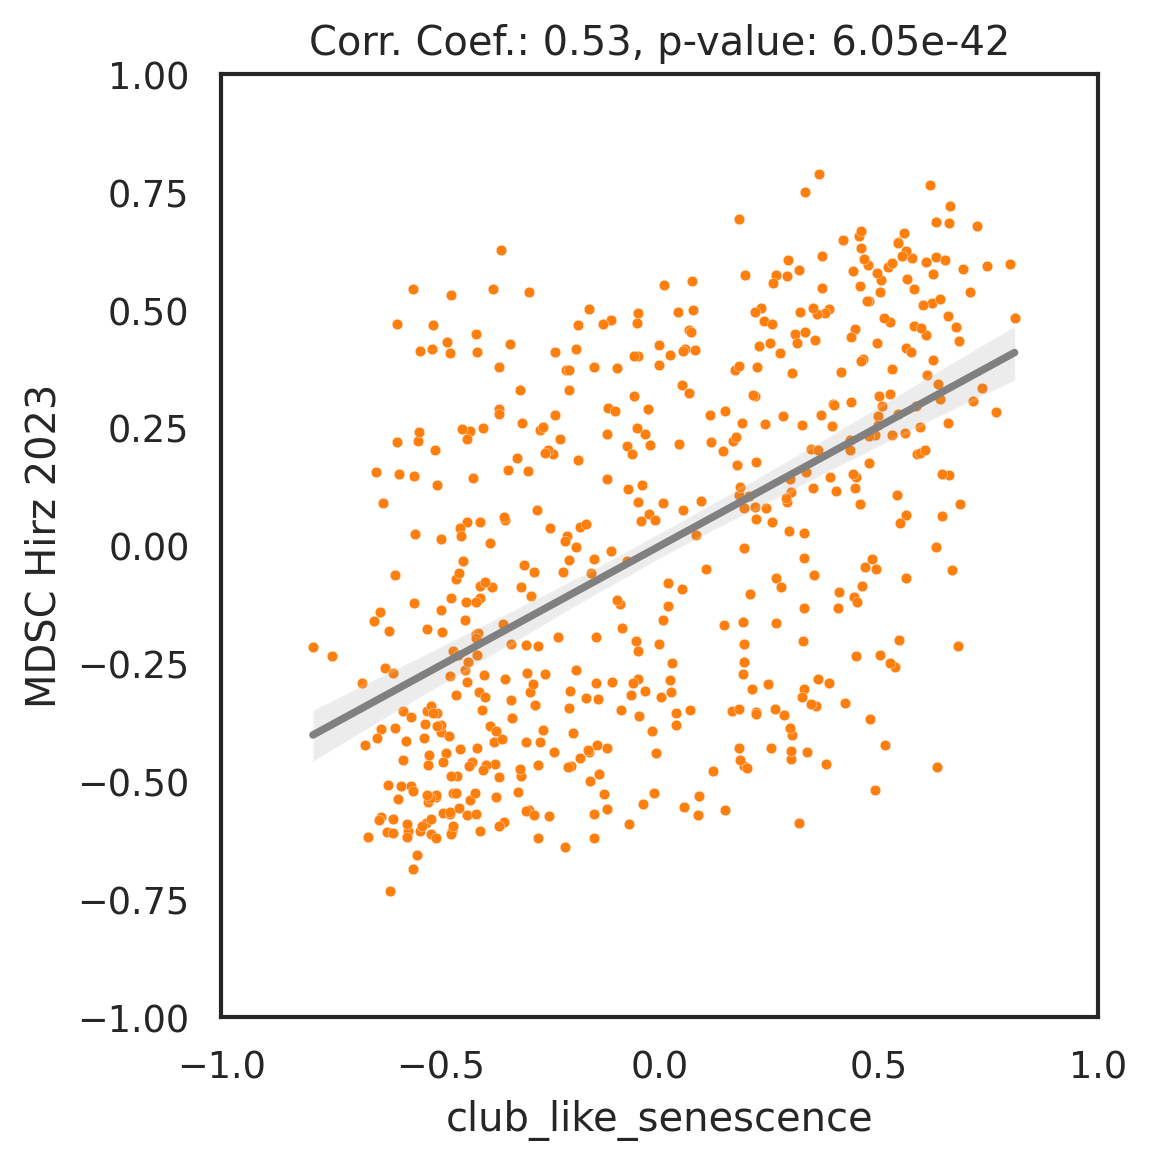

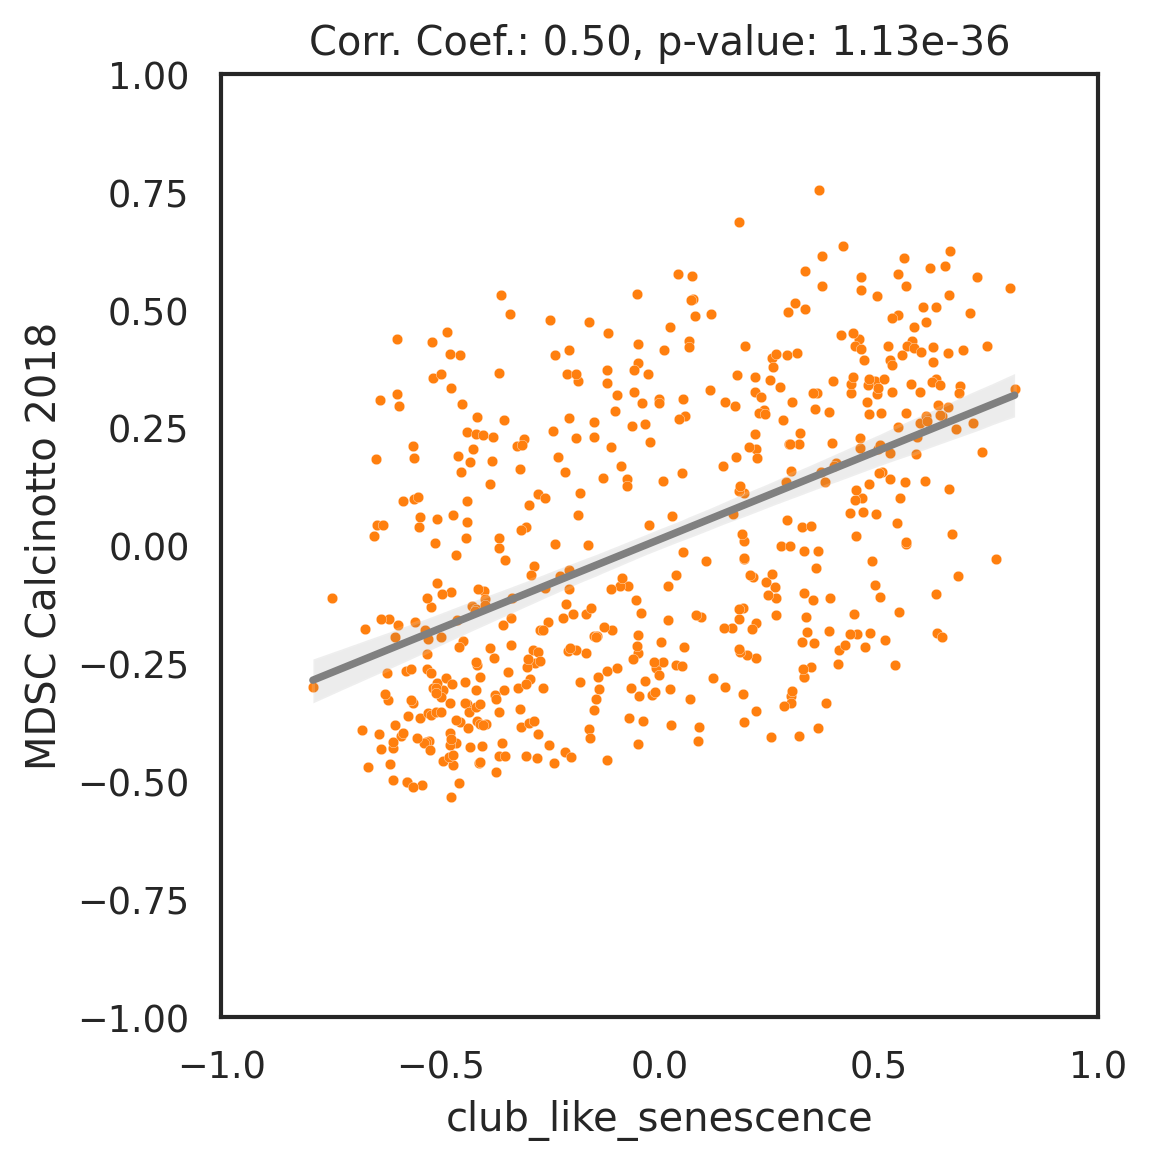

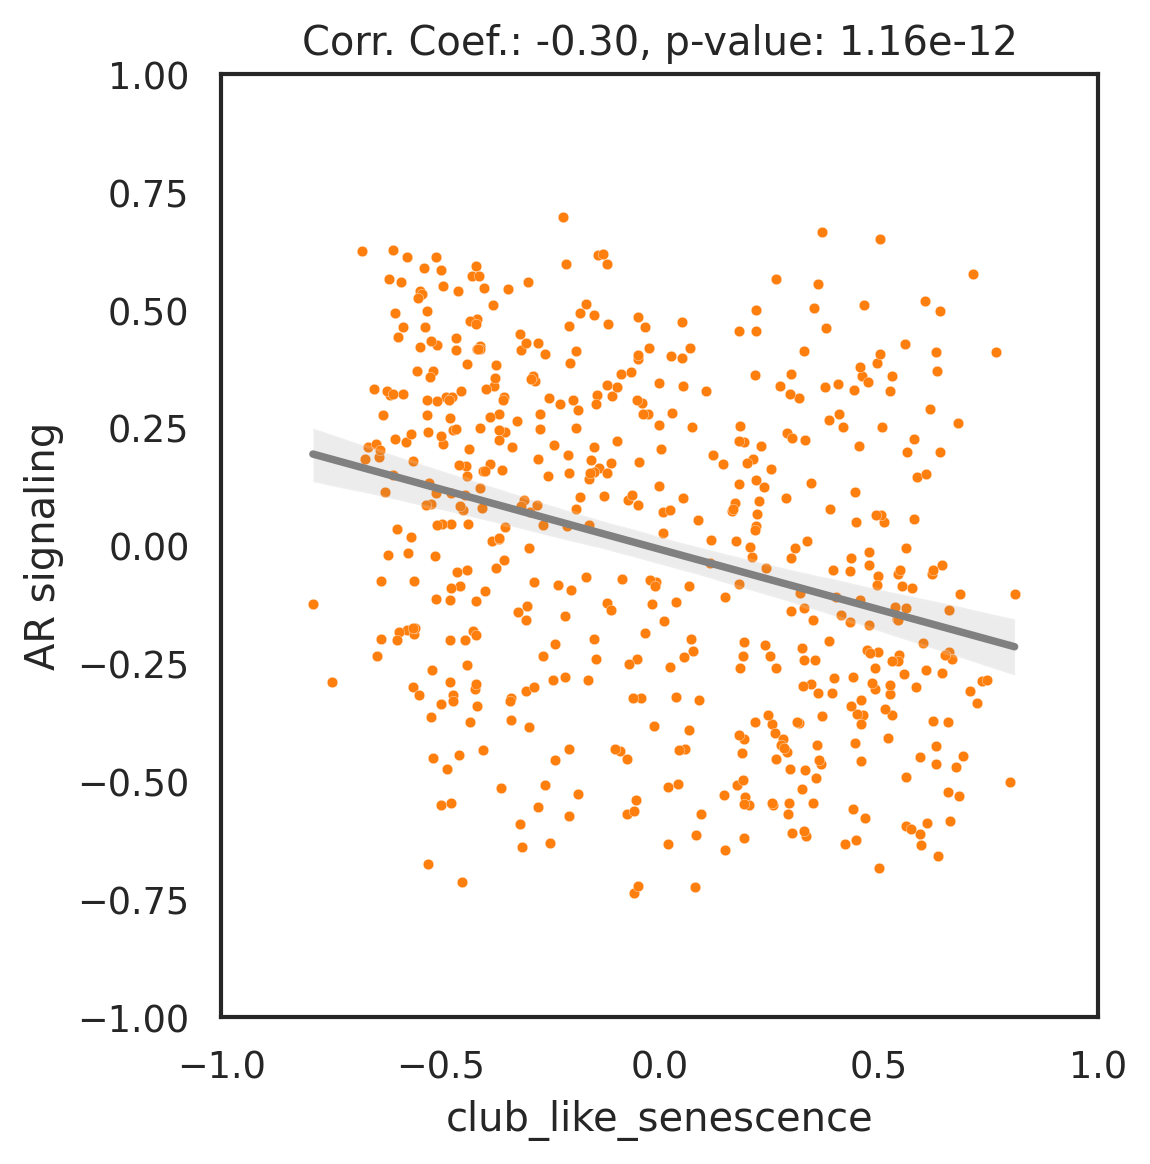

In [102]:
sns.set_theme(style='white')

signature1 = 'club_like_senescence'
signature2s = ['High NLR-associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']

# Create a new dict structure with no overlaps
simple_gene_modules_dict = {
    signature1: gene_modules_dict[signature1]
}
for signature2 in signature2s:
    simple_gene_modules_dict[signature2] = set(gene_modules_dict[signature2]).difference(gene_modules_dict[signature1]) # Only remove the overlap from one gene set


# Need to run new scoring after getting rid of the overlap between two genes
gsva_res = gp.gsva(data=tcga_counts_dat,gene_sets=simple_gene_modules_dict,outdir=None,min_size=0)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Convert to float
gsva_res_df[signature1] = gsva_res_df[signature1].astype(float)

for signature2 in signature2s:

    # Convert to float
    gsva_res_df[signature2] = gsva_res_df[signature2].astype(float)

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=signature1, y=signature2, data=gsva_res_df, linewidth=0.1, s=10, ax=ax,legend=False,color='#ff7f0e') # 

    # add regression line to plot
    sns.regplot(x=signature1, y=signature2, data=gsva_res_df, scatter=False, ax=ax,color='gray')

    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(-1.0,1.0)
    corr_coef, p_value = spearmanr(gsva_res_df[signature1], gsva_res_df[signature2])


    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()

    plt.savefig('plots/score_correlations/TCGA_'+signature1.replace(' ','_')+signature2.replace(' ','_')+'_signature_correlation_in_bulk_no_overlap.pdf')

    plt.show()

gsva_res_df.to_excel('./source_data/figure_5g.xlsx')

### SU2C-PCF metastatic CRPC samples

In [98]:
# The data was downloaded from https://www.cbioportal.org/study/summary?id=prad_su2c_2019
dat_polya = pd.read_csv('bulk_RNAseq/prad_su2c_2019/data_mrna_seq_fpkm_polya_zscores_ref_all_samples.txt',sep='\t',index_col=0)


2024-07-30 10:11:41,998 [WARNING] Input data contains NA, filled NA with 0
2024-07-30 10:11:42,021 [WARNING] Found duplicated gene names, values averaged by gene names!


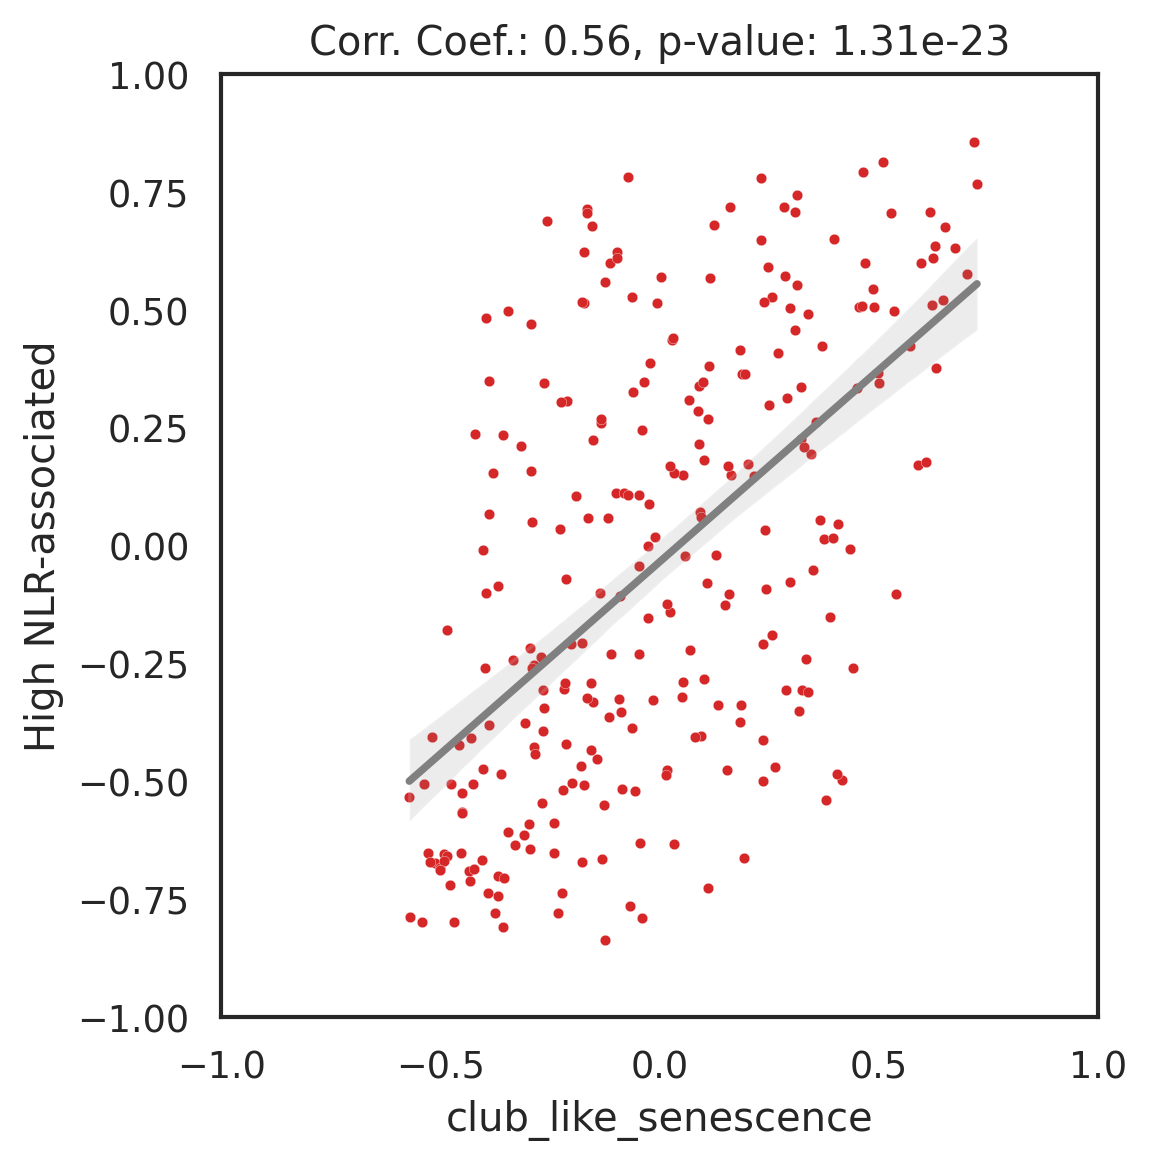

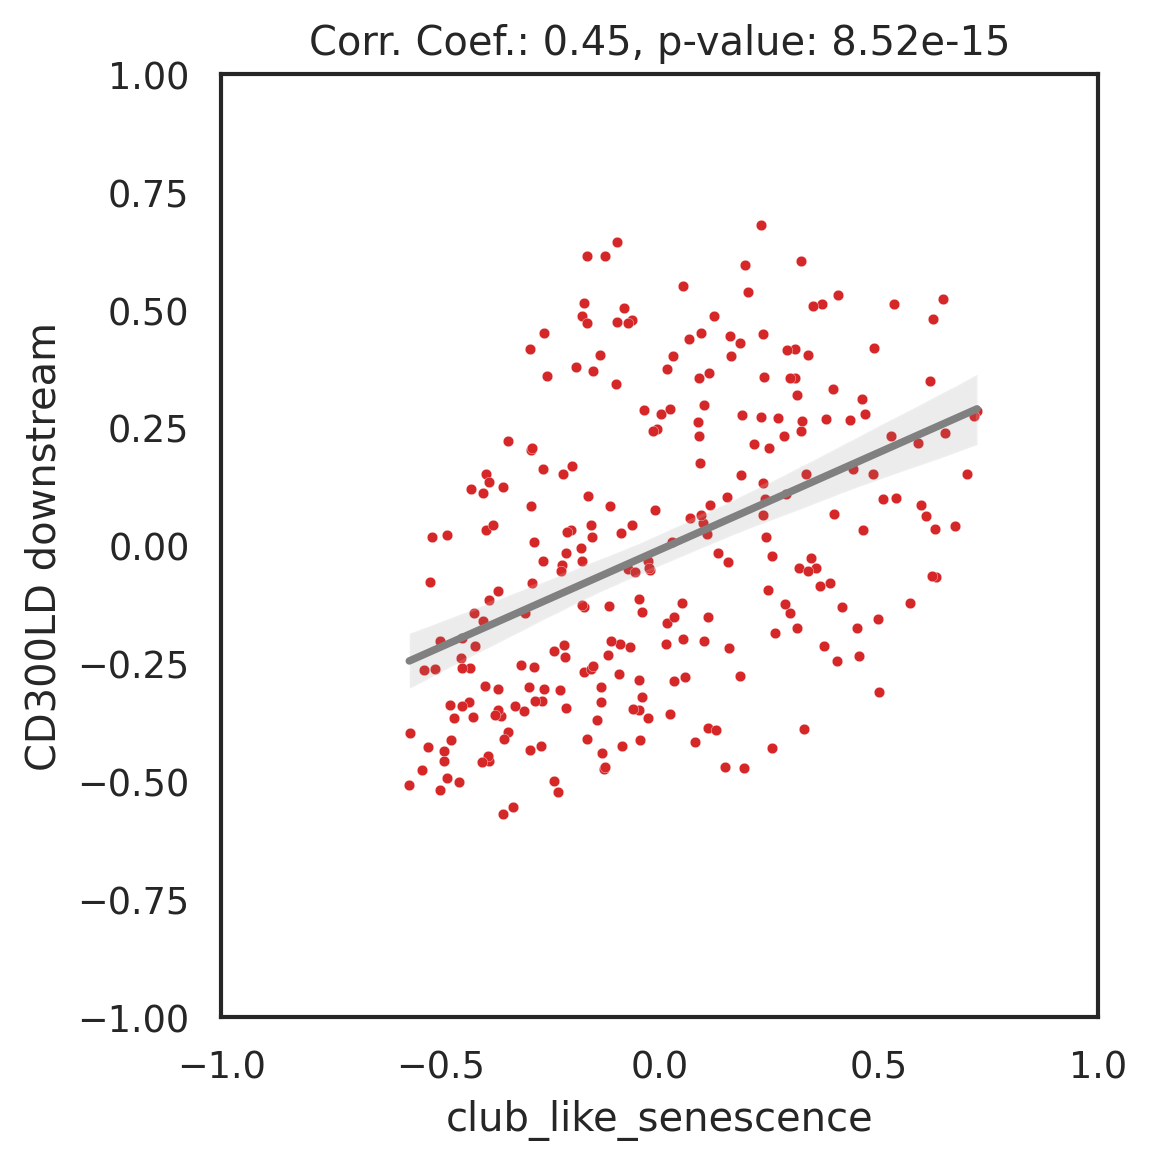

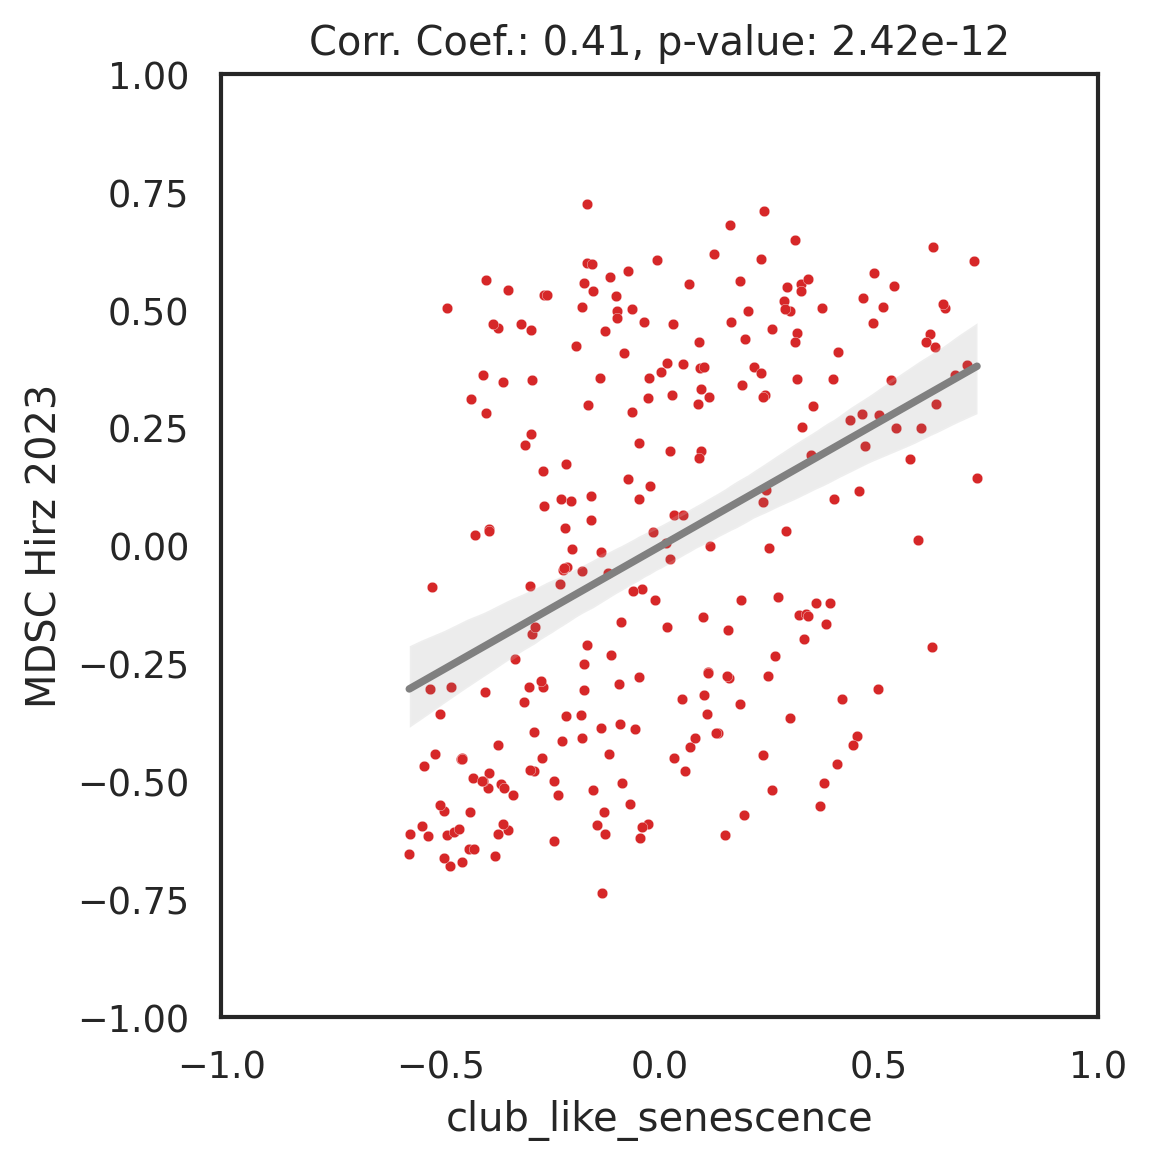

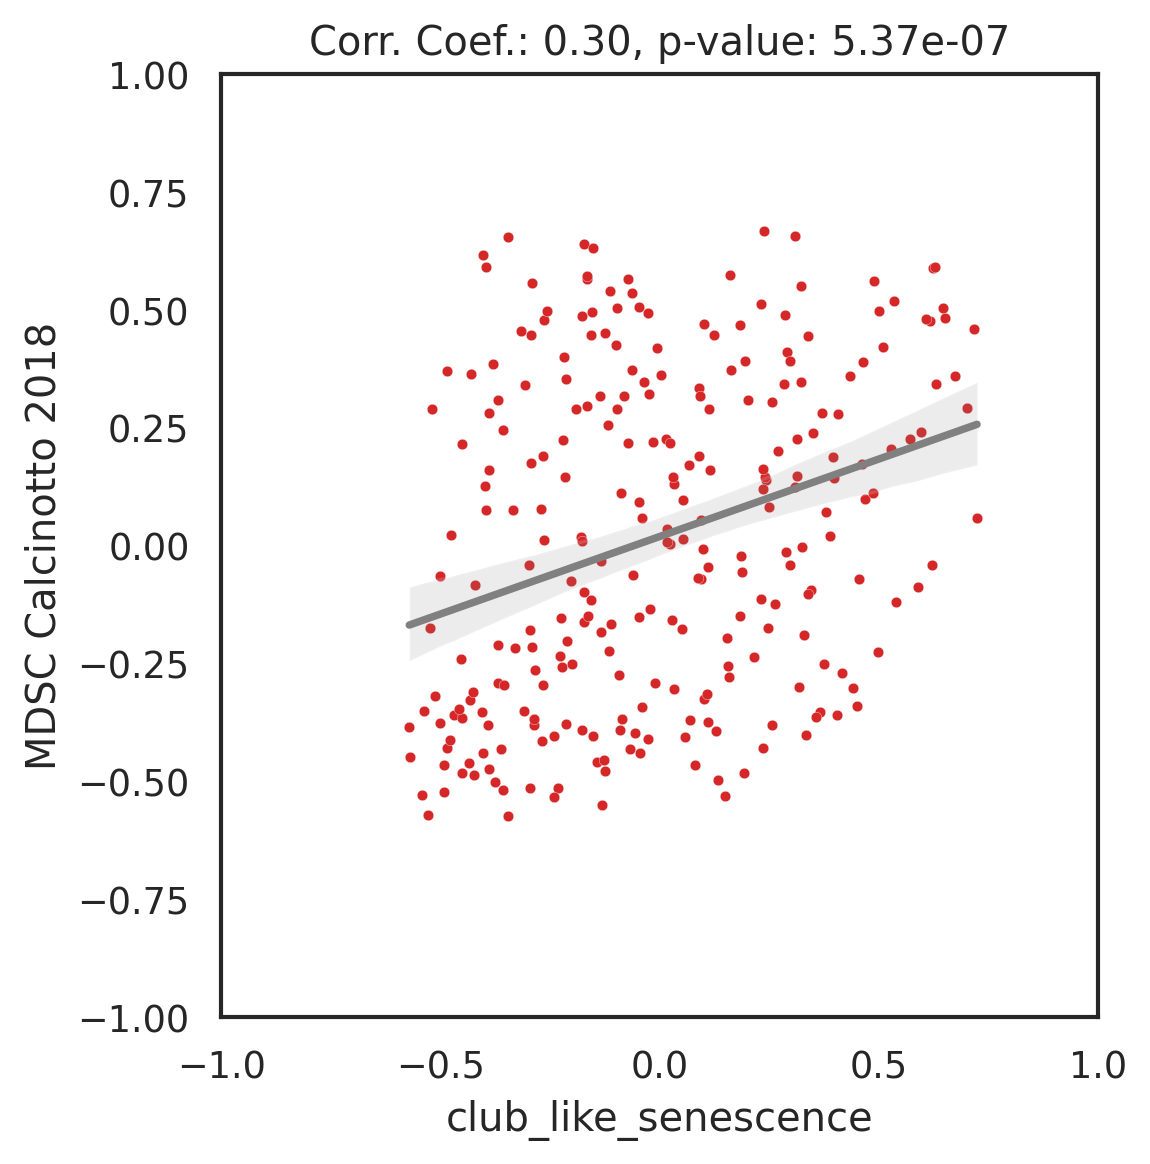

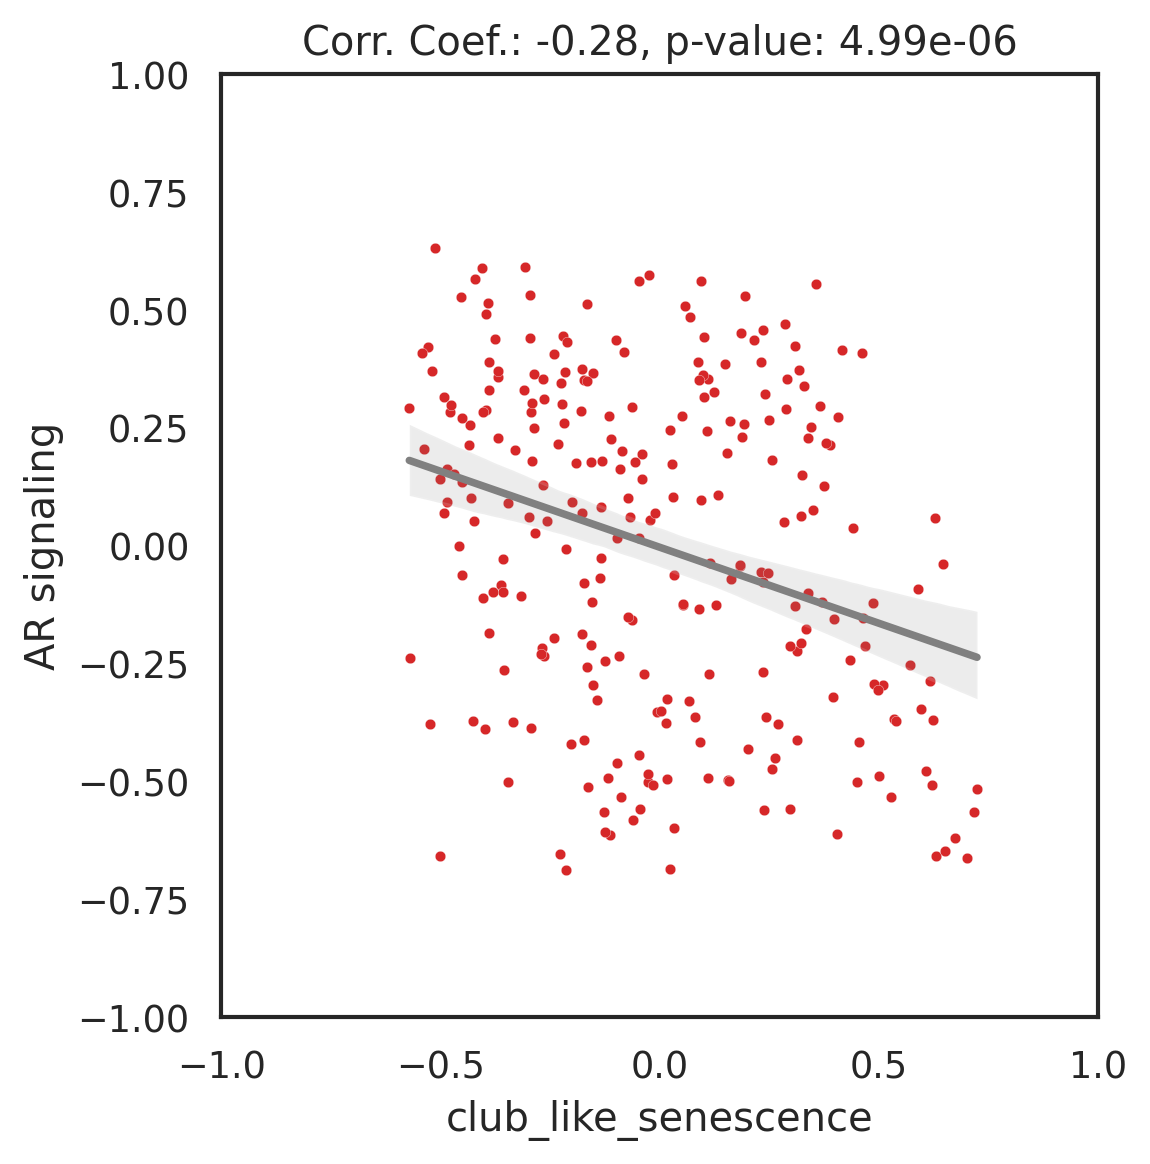

In [100]:
signature1 = 'club_like_senescence'
signature2s = ['High NLR-associated','CD300LD downstream','MDSC Hirz 2023','MDSC Calcinotto 2018','AR signaling']

# Create a new dict structure with no overlaps
simple_gene_modules_dict = {
    signature1: gene_modules_dict[signature1]
}
for signature2 in signature2s:
    simple_gene_modules_dict[signature2] = set(gene_modules_dict[signature2]).difference(gene_modules_dict[signature1]) # Only remove the overlap from one gene set

# Run scoring
gsva_res = gp.gsva(data=dat_polya,gene_sets=simple_gene_modules_dict,outdir=None,min_size=0)
gsva_res_df = gsva_res.res2d.pivot(index='Name', columns='Term', values='ES').reset_index(names='Sample Identifier')

# Convert to float
gsva_res_df[signature1] = gsva_res_df[signature1].astype(float)

for signature2 in signature2s:

    # Convert to float
    gsva_res_df[signature2] = gsva_res_df[signature2].astype(float)

    ## PLOT ##
    fig, ax = plt.subplots(figsize=(5,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=signature1, y=signature2, data=gsva_res_df, linewidth=0.1, s=10, ax=ax,legend=False,color='#d62728') # 

    # add regression line to plot
    sns.regplot(x=signature1, y=signature2, data=gsva_res_df, scatter=False, ax=ax,color='gray')

    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(-1.0,1.0)
    
    corr_coef, p_value = spearmanr(gsva_res_df[signature1], gsva_res_df[signature2])

    ax.set_title(f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")
    plt.tight_layout()

    plt.savefig('plots/score_correlations/SU2C_'+signature1.replace(' ','_')+signature2.replace(' ','_')+'_signature_correlation_in_bulk_no_overlap.pdf')
    plt.show()
    
gsva_res_df.to_excel('./source_data/figure_5h.xlsx')